# Correlation Between Draws 

In order to run the CVD model in 51 locations, we will need to limit the number of draws we use. One plan for doing this is selecting draws based on a much larger run in one state for use throughout the model. However, for that to work effectively the draws need to be correlated between state (e.g., the high draw in one state is also high in another state) even if they are different actual values. 

We will test in this notebook to see if that is actually true. 

### Starting with Incidence of AMI for Alabama, Washington and US 

I will use MEID 24694 which is AMI from IHD. While it is adjusted by prevalence in our model, I will not adjust it here since this is correlation.

In [40]:
import pandas as pd, numpy as np, os
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import random
import scipy.stats

In [22]:
MI_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=523,
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=24694,
         measure_id=6,
         source='epi')

In [31]:
data_a = MI_inc.set_index(['sex_id','modelable_entity_id','age_group_id'])
data_a = (data_a[[c for c in data_a.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data_a = (data_a.pivot_table(index=['sex_id','age_group_id','draw'], columns='modelable_entity_id', values='value')
        .reset_index())
data_a = data_a.rename(columns={24694:'Alabama'})
#data_a.head()

In [32]:
MI_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=570,
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=24694,
         measure_id=6,
         source='epi')

data_w = MI_inc.set_index(['sex_id','modelable_entity_id','age_group_id'])
data_w = (data_w[[c for c in data_w.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data_w = (data_w.pivot_table(index=['sex_id','age_group_id','draw'], columns='modelable_entity_id', values='value')
        .reset_index())
data_w = data_w.rename(columns={24694:'Washington'})
#data_w.head()

In [33]:
MI_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=102,
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=24694,
         measure_id=6,
         source='epi')

data_us = MI_inc.set_index(['sex_id','modelable_entity_id','age_group_id'])
data_us = (data_us[[c for c in data_us.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data_us = (data_us.pivot_table(index=['sex_id','age_group_id','draw'], columns='modelable_entity_id', values='value')
        .reset_index())
data_us = data_us.rename(columns={24694:'US'})
#data_us.head()

In [37]:
data_merged = data_a.merge(data_w[['draw','Washington']], on=['draw']).merge(data_us[['draw','US']], on=['draw'])
data_merged.head()

modelable_entity_id,sex_id,age_group_id,draw,Alabama,Washington,US
0,2,18,draw_0,0.004217,0.003529,0.004217
1,2,18,draw_1,0.004806,0.003971,0.004806
2,2,18,draw_10,0.004317,0.003554,0.004317
3,2,18,draw_100,0.005200,0.003942,0.005200
4,2,18,draw_101,0.005179,0.004126,0.005179


In [44]:
a_w, p_val = scipy.stats.spearmanr(data_merged['Alabama'], data_merged['Washington'])
a_us, p_val = scipy.stats.spearmanr(data_merged['Alabama'], data_merged['US'])
us_w, p_val = scipy.stats.spearmanr(data_merged['Washington'], data_merged['US'])
print(a_w, a_us, us_w)

0.8924887484887486 1.0 0.8924887484887486


### Expanding to all locations

This seems like there is high correlation! But not 100% for all of them. Let's make sure this works for all of the states in a more systematic way. To simplify all of the possible correlations, I think we will compare all of the states to the full US.

In [95]:
MI_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=24694,
         measure_id=6,
         source='epi')

In [96]:
MI_inc_edited = MI_inc.drop(['age_group_id','measure_id','sex_id','year_id','metric_id','model_version_id','modelable_entity_id'], axis=1)
MI_inc_edited = MI_inc_edited.transpose()
MI_inc_edited.columns = MI_inc_edited.iloc[1000]
MI_inc_edited = MI_inc_edited.drop(['location_id'], axis=0)
#MI_inc_edited

In [92]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(MI_inc_edited.iloc[:,i], MI_inc_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])

df

,corr,p_val
0,0.896026,0.0
1,0.897285,0.0
2,0.906684,0.0
3,0.875086,0.0
4,0.898085,0.0
5,0.927159,0.0
6,0.889075,0.0
7,0.897843,0.0
8,0.862419,0.0
9,0.876381,0.0


In [94]:
min(df['corr'])

0.8615414255414257

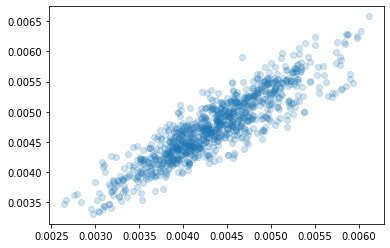

In [127]:
plt.scatter(MI_inc_edited[550.0], MI_inc_edited[102.0], alpha=0.2)

Seems like they are highly correlated! The lowest correlation value is 0.86 which is still pretty high. This is a promising sign. 

### Testing a few other data types 

It is impractical for me to test all of the input data sources.I will test a couple more to ensure this is consistent across different types of data. I did incidence before. I will test a mean risk factor value and a RR value.

To start with, I will do the SBP mean value. 

In [100]:
sbp_mean = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=2547,
         source='stgpr')

In [104]:
sbp_mean_edited = sbp_mean.drop(['age_group_id','measure_id','sex_id','year_id','stgpr_model_version_id','modelable_entity_id'], axis=1)
sbp_mean_edited = sbp_mean_edited.transpose()
sbp_mean_edited.columns = sbp_mean_edited.iloc[1000]
sbp_mean_edited = sbp_mean_edited.drop(['location_id'], axis=0)
#sbp_mean_edited

In [105]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(sbp_mean_edited.iloc[:,i], sbp_mean_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])

df

,corr,p_val
0,0.476898,0.0
1,0.461254,0.0
2,0.455735,0.0
3,0.504375,0.0
4,1.0,0.0
5,0.484042,0.0
6,0.498576,0.0
7,0.500265,0.0
8,0.510036,0.0
9,0.461336,0.0


In [107]:
min(df['corr'])

0.4153212433212433

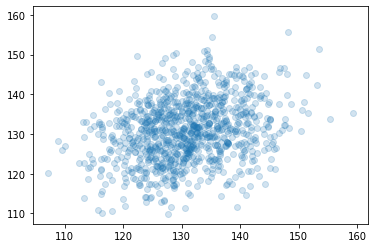

In [125]:
plt.scatter(sbp_mean_edited[570.0], sbp_mean_edited[552.0], alpha = 0.2)

Wow that is way more different than I was anticipating. I 

### SBP Standard Deviaiton

In [114]:
sbp_std = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=15788,
         source='epi')

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


In [118]:
sbp_std_edited = sbp_std.drop(['age_group_id','measure_id','metric_id','sex_id','year_id','model_version_id','modelable_entity_id'], axis=1)
sbp_std_edited = sbp_std_edited.transpose()
sbp_std_edited.columns = sbp_std_edited.iloc[1000]
sbp_std_edited = sbp_std_edited.drop(['location_id'], axis=0)
#sbp_std_edited

In [120]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(sbp_std_edited.iloc[:,i], sbp_std_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])

df

,corr,p_val
0,0.996283,0.0
1,0.999201,0.0
2,0.989856,0.0
3,0.998671,0.0
4,0.994123,0.0
5,0.997546,0.0
6,0.999953,0.0
7,0.993909,0.0
8,0.999883,0.0
9,0.986187,0.0


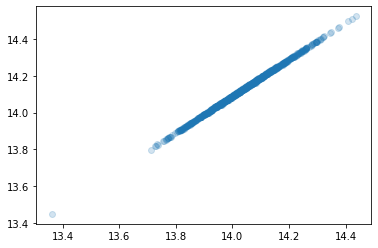

In [126]:
plt.scatter(sbp_std_edited[550.0], sbp_std_edited[102.0], alpha =0.2)